In [197]:
import pandas as pd
import pprint as pp
import numpy as np

In [202]:
train_df_raw = pd.read_csv('./data/articles_training.csv', encoding = 'utf-8')
train_df_raw.columns

Index([u'id', u'author', u'channel', u'content', u'content_sentiment_polarity',
       u'content_subjectivity', u'link', u'n_tokens_content',
       u'n_tokens_title', u'num_hrefs', u'num_imgs', u'num_keywords',
       u'num_self_hrefs', u'num_videos', u'post_date', u'shares', u'timedelta',
       u'title', u'title_sentiment_polarity', u'title_subjectivity', u'topics',
       u'type'],
      dtype='object')

In [201]:
train_df_raw.shape

(1555, 22)

In [203]:
range(2,20)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [100]:
def dummify(df, cate_variables):
    '''
    @Summary: convert the categorical variables to numeric variables by using dummies (binary).
    Old categorical variables will be dropped.
    @return: A copy of the old dataframe with new converted numeric variables. 
    '''
    # make a copy before creating dummies
    df_new = df.copy()
    
    # convert text-based columns to dummies (except v22)
    for var_name in cate_variables:
        dummies = pd.get_dummies(df[var_name], prefix=var_name)
        
        # Drop the current variable, concat/append the dummy dataframe to the dataframe.
        df_new = pd.concat([df_new.drop(var_name, 1), dummies.iloc[:,1:]], axis = 1)
    
    return df_new

In [126]:
def data_transform(df):
    df_new = df.drop(['id', 'post_date', 'type', 'content', 'title', 'link', 'topics', 'author', 'shares'], axis = 1)
    cate_variables = ['channel']
    x_train = dummify(df_new, cate_variables)
    y_train = (df['shares'] > 1400) + 0

    return (x_train, y_train)

test_df_raw = pd.read_csv('./data/articles_test.csv')

x_train, y_train = data_transform(train_df_raw)

x_test, y_test = data_transform(test_df_raw)

print train_df_raw.columns
print test_df_raw.columns
#pp.pprint(y_train)

#pp.pprint(x_train.head())
#pp.pprint(y_train.head())

Index([u'id', u'author', u'channel', u'content', u'content_sentiment_polarity',
       u'content_subjectivity', u'link', u'n_tokens_content',
       u'n_tokens_title', u'num_hrefs', u'num_imgs', u'num_keywords',
       u'num_self_hrefs', u'num_videos', u'post_date', u'shares', u'timedelta',
       u'title', u'title_sentiment_polarity', u'title_subjectivity', u'topics',
       u'type'],
      dtype='object')
Index([u'id', u'author', u'channel', u'content', u'content_sentiment_polarity',
       u'content_subjectivity', u'link', u'n_tokens_content',
       u'n_tokens_title', u'num_hrefs', u'num_imgs', u'num_keywords',
       u'num_self_hrefs', u'num_videos', u'post_date', u'shares', u'timedelta',
       u'title', u'title_sentiment_polarity', u'title_subjectivity', u'topics',
       u'type'],
      dtype='object')


In [128]:
from sklearn import ensemble

def fit_and_score(x_train, y_train, x_test, y_test, model, show = True):
    model.fit(x_train, y_train)
    train_error = 1 - model.score(x_train, y_train)
    test_error = 1 - model.score(x_test, y_test)
    if show:
        print "The training error is: %.5f" %train_error 
        print "The test     error is: %.5f" %test_error
    return [train_error, test_error]

randomForest = ensemble.RandomForestClassifier()
#randomForest.set_params(max_depth = 10)
print randomForest.get_params()

fit_and_score(x_train, y_train, x_test, y_test, randomForest)

{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'auto', 'max_depth': None, 'class_weight': None}
The training error is: 0.02508
The test     error is: 0.38000


[0.025080385852090048, 0.38]

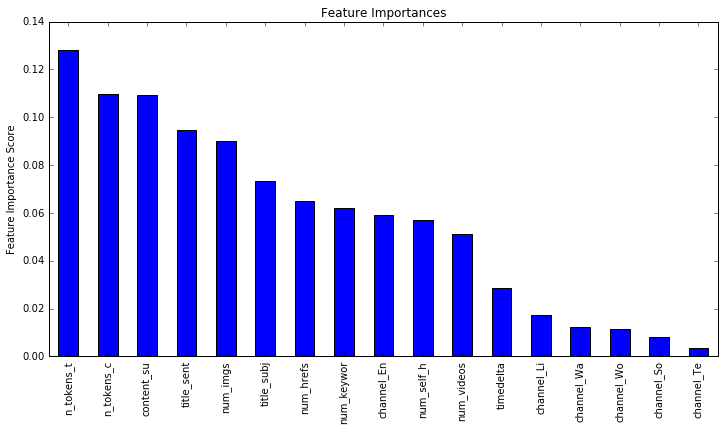

In [192]:
def get_feature_importance(df, model):    
    feature_imprtance = zip(df.columns[1:], model.feature_importances_)
    dtype = [('feature', 'S10'), ('importance', 'float')]
    feature_imprtance = np.array(feature_imprtance, dtype = dtype)
    feature_sort = np.sort(feature_imprtance, order='importance')[::-1]
    return feature_sort
 
feature_importance = get_feature_importance(x_train, randomForest)    
#pp.pprint(feature_importance)

x_plot = [feature for feature, importance in feature_importance]
y_plot = [importance for feature, importance in feature_importance]

import matplotlib.pyplot as plt
%matplotlib inline

feat_imp = pd.Series(y_plot, x_plot).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,6))
plt.ylabel('Feature Importance Score')

In [195]:
import sklearn.grid_search as gs 

grid_para_forest = {'criterion': ['gini', 'entropy'], 'max_depth': range(2, 20), "n_estimators": range(10, 100, 10)}
grid_search_forest = gs.GridSearchCV(randomForest, grid_para_forest, cv=5, scoring='accuracy').fit(x_train, y_train)

print 'The best score is %.4f' %grid_search_forest.best_score_
print 'The best parameters are %s' %grid_search_forest.best_params_
print 'The training error is %.4f' %(1 - grid_search_forest.score(x_train, y_train))
print 'The testing error is %.4f' %(1 - grid_search_forest.score(x_test, y_test))

The best score is 0.7113
The best parameters are {'n_estimators': 60, 'criterion': 'entropy', 'max_depth': 16}
The training error is 0.0154
The testing error is 0.3150


/Users/binlin/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


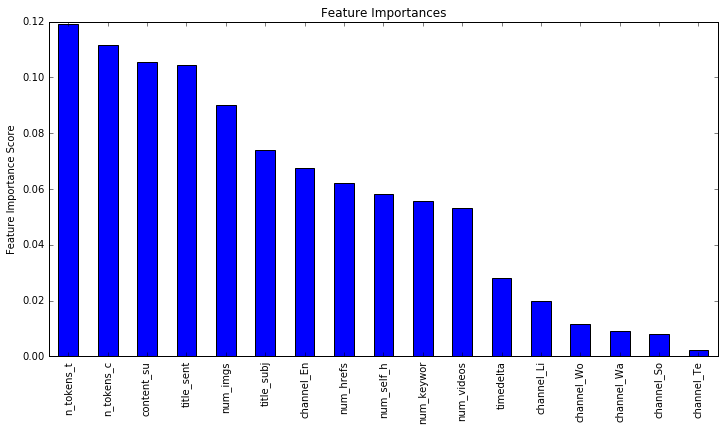

In [196]:
forest_final = grid_search_forest.best_estimator_

feature_importance = get_feature_importance(x_train, forest_final)    

x_plot = [feature for feature, importance in feature_importance]
y_plot = [importance for feature, importance in feature_importance]

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.subplots_adjust(bottom=0.2)
ax = fig.add_subplot(111)

feat_imp = pd.Series(y_plot, x_plot).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,6))
plt.ylabel('Feature Importance Score')